# Physic Informed Machine learning for parameter estimation
In this notebook, we will use the optimizer to estimate the parameters of the voltage source converter (VSC). This estimation is based on the impedance model and the impedance measurement results.

Tensorflow is selected as the tool since almost all the most advanced optimizers are built in Tensorflow. For simplicity, eager excersion is used for better interactive result displaying.

## Import all the libaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IM_tf_train as im
import tensorflow as tf
import time
import math
from tensorflow.linalg import inv
import ControlDesign as CD
import SweepAnalysis as SA
%matplotlib ipympl

## Prepare the data

Since we will get the data from the analytical model at this stage, let us create the analytical model first.

In [2]:
Rfilter = 2e-2
Lfilter = 250e-6
Cout = 3000e-6 # Two 3 mF capacitors are connected in series at the DC side of the AC/DC converter
fsw = 20e3 # The switching frequency is 20 kHz
Vdc = 800  # The DC-link voltage is set to 800V
DCFC_Power = 30e3 # Operating power of the DC fast charger
Vsd = 230*np.sqrt(2)
Grid_Vsdq = np.array([Vsd, 0])
Grid_freq = 50 # The grid frequency is 50 Hz
fcPLL = 30 # Bandwidth of the PLL
fci = 800  # Bandwidth of the current control loop
fcv = 330   # Bandwidth of the voltage control loop
# phi_u = 45/180*np.pi # Phase margin of the voltage loop
f_range = np.concatenate([np.arange(1,50,10),np.arange(51,3000+1,10)]) # 50Hz need to be removed

Kpi:1.256637,
Kii:100.530965,
Kpu:6.148755,
Kiu:254.664516.


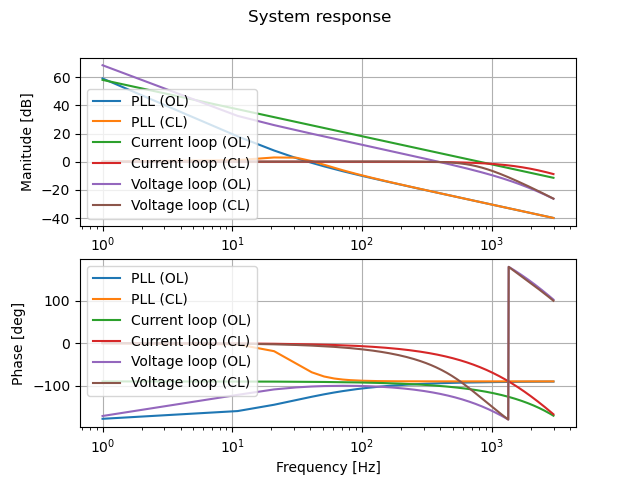

In [3]:
Kppll,Kipll,Kpi,Kii,Kpu,Kiu=CD.design_ctrl(fcPLL,fci,fcv,Lfilter,Rfilter,Vsd,Cout,Vdc,1,1)
CD.bode_plot(Rfilter,Lfilter,Kppll,Kipll,Kpi,Kii,Kpu,Kiu,Vsd,Vdc,Cout,fsw,f_range)

Below, it shows the sampled data for the parameter estimation.

Firstly, we give the parameters of the converter.

In [4]:
Rfilter_ts = tf.Variable([2e-2], dtype=tf.float32)
Lfilter_ts = tf.Variable([250e-6], dtype=tf.float32)
kpi_ts = tf.Variable([Kpi], dtype=tf.float32)
kii_ts = tf.Variable([Kii], dtype=tf.float32)
kppll_ts = tf.Variable([Kppll], dtype=tf.float32)
kipll_ts = tf.Variable([Kipll], dtype=tf.float32)
kpu_ts = tf.Variable([Kpu], dtype=tf.float32)
kiu_ts = tf.Variable([Kiu], dtype=tf.float32)
fsw_ts = tf.Variable([fsw], dtype=tf.float32)
Cout_ts = tf.Variable([Cout], dtype=tf.float32)
Vdc_ts = tf.Variable([Vdc], dtype=tf.float32)

Then, the impedance sampled at low frequencies are given.

(52, 1)


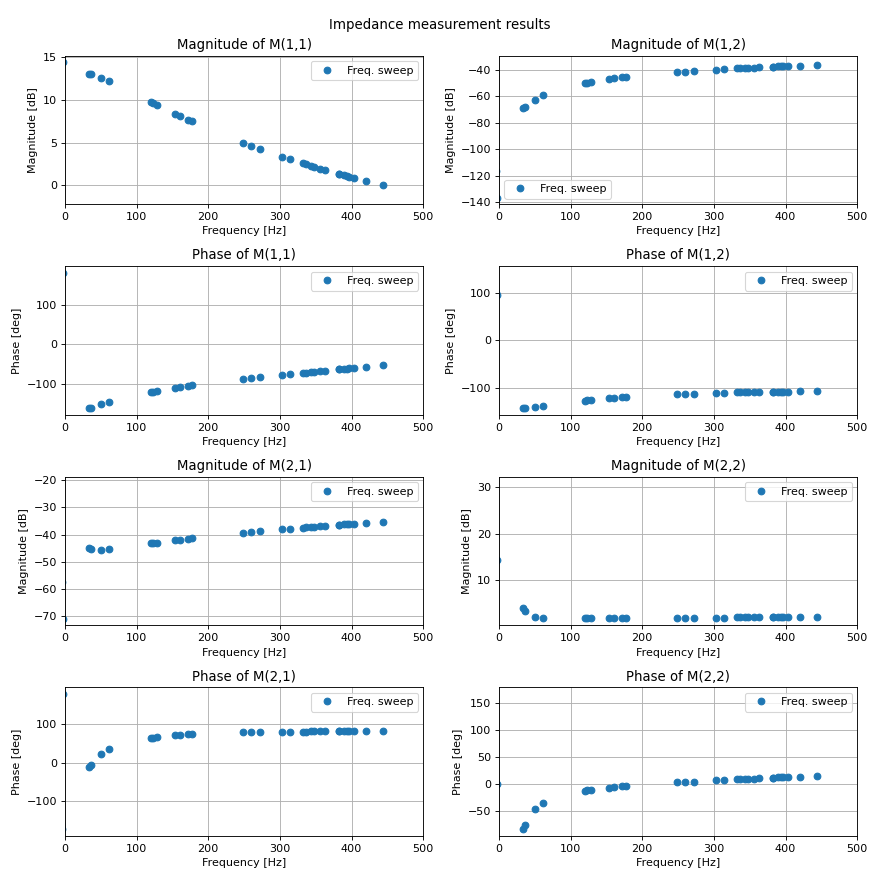

In [5]:
Nlf_points = 30
Nhf_points = 30
f_sweep_lf1 = np.sort(np.unique(np.random.randint(1,50,size=(Nlf_points,1))))
f_sweep_lf2 = np.sort(np.unique(np.random.randint(51,500,size=(Nhf_points,1))))
f_sweep_lf = np.concatenate([f_sweep_lf1,f_sweep_lf2])
# f_PIML = np.array([51,52])
f_sweep_lf = f_sweep_lf.reshape(f_sweep_lf.shape[0],1)
print(f_sweep_lf.shape)

f_sweep_lf_ts = tf.constant(f_sweep_lf.reshape(f_sweep_lf.shape[0]),dtype=tf.int32)
Ana_model_lf = im.Impedance_model1(Rfilter_ts,Lfilter_ts,kpi_ts,kii_ts,kppll_ts,kipll_ts,kpu_ts,kiu_ts,
                                        fsw_ts,Cout_ts,Vdc_ts,Grid_freq,Grid_Vsdq,DCFC_Power,f_sweep_lf_ts)
Z_exact_lf_n,Z_exact_lf_p = tf.split(Ana_model_lf.Zvd_vl_dq,2,axis=0)
Z_exact_lf_p_np = Z_exact_lf_p.numpy()

SA.Impedance_plotting(Ana_model_lf.f_dq,Ana_model_lf.f_dq,0,'Impedance measurement results',[0,500],
                        'o',**{'Freq. sweep':Ana_model_lf.Zvd_vl_dq})

Then, the impedance sampled at high frequencies are given.

(60, 1)


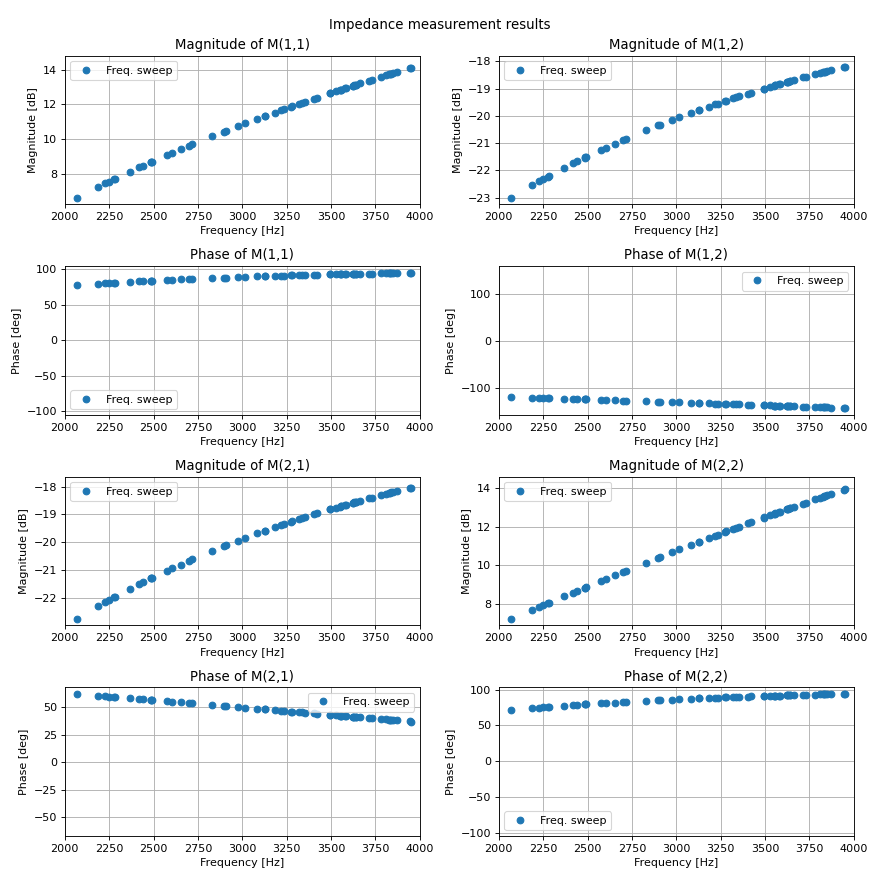

In [6]:
Nvhf_points = 60 # samples for current controller parameters estimation
f_sweep_hf = np.sort(np.unique(np.random.randint(2000,4000,size=(Nvhf_points,1))))
f_sweep_hf = f_sweep_hf.reshape(f_sweep_hf.shape[0],1)
print(f_sweep_hf.shape)

f_sweep_hf_ts = tf.constant(f_sweep_hf.reshape(f_sweep_hf.shape[0]),dtype=tf.int32)
Ana_model_hf = im.Impedance_model1(Rfilter_ts,Lfilter_ts,kpi_ts,kii_ts,kppll_ts,kipll_ts,kpu_ts,kiu_ts,
                                        fsw_ts,Cout_ts,Vdc_ts,Grid_freq,Grid_Vsdq,DCFC_Power,f_sweep_hf_ts)
Z_exact_hf_n,Z_exact_hf_p = tf.split(Ana_model_hf.Zvd_vl_dq,2,axis=0)
Z_exact_hf_p_np = Z_exact_hf_p.numpy()

SA.Impedance_plotting(Ana_model_hf.f_dq,Ana_model_hf.f_dq,0,'Impedance measurement results',[2000,4000],
                        'o',**{'Freq. sweep':Ana_model_hf.Zvd_vl_dq})

In [7]:
# # This is the implementation after changing the data obtained from dq-frame to synchronous frame.
# Nlf_points = 30
# Nhf_points = 30
# f_sweep_lf1 = np.sort(np.unique(np.random.randint(1,50,size=(Nlf_points,1))))
# f_sweep_lf2 = np.sort(np.unique(np.random.randint(51,500,size=(Nhf_points,1))))
# f_sweep_lf = np.concatenate([f_sweep_lf1,f_sweep_lf2])
# # f_PIML = np.array([51,52])
# f_sweep_lf = f_sweep_lf.reshape(f_sweep_lf.shape[0],1)
# print(f_sweep_lf.shape)

# f_sweep_lf_ts = tf.constant(f_sweep_lf.reshape(f_sweep_lf.shape[0]),dtype=tf.int32)
# Ana_model_lf = im.Impedance_model1(Rfilter_ts,Lfilter_ts,kpi_ts,kii_ts,kppll_ts,kipll_ts,kpu_ts,kiu_ts,
#                                         fsw_ts,Cout_ts,Vdc_ts,Grid_freq,Grid_Vsdq,DCFC_Power,f_sweep_lf_ts)
# Z_exact_lf = Ana_model_lf.Zvd_vl_ab
# Z_exact_lf_np = Z_exact_lf.numpy()

# SA.Impedance_plotting(f_sweep_lf,f_sweep_lf,0,'Impedance measurement results',[0,500],
#                         'o',**{'Freq. sweep':Z_exact_lf_np})

Define the class of the PIML (when neglecting the DC-link voltage ripple)

In [8]:
class PhysicsInformedMLIM:
    # Initialize the class
    def __init__(self, LF, Z_lf,HF, Z_hf,Grid_freq,Grid_Vsdq,DCFC_Power,l_rate):
        self.Grid_freq = Grid_freq
        self.Grid_Vsdq = Grid_Vsdq
        self.DCFC_Power = DCFC_Power
        # Low frequency samples
        self.lf = LF
        self.zdd_lf_real = Z_lf[:,0,0].reshape((Z_lf.shape[0]),1).real
        self.zdd_lf_imag = Z_lf[:,0,0].reshape((Z_lf.shape[0]),1).imag

        self.zdq_lf_real = Z_lf[:,0,1].reshape((Z_lf.shape[0]),1).real
        self.zdq_lf_imag = Z_lf[:,0,1].reshape((Z_lf.shape[0]),1).imag

        self.zqd_lf_real = Z_lf[:,1,0].reshape((Z_lf.shape[0]),1).real
        self.zqd_lf_imag = Z_lf[:,1,0].reshape((Z_lf.shape[0]),1).imag

        self.zqq_lf_real = Z_lf[:,1,1].reshape((Z_lf.shape[0]),1).real
        self.zqq_lf_imag = Z_lf[:,1,1].reshape((Z_lf.shape[0]),1).imag

        self.zdd_lf_real_max = tf.reduce_max(self.zdd_lf_real)
        self.zdd_lf_imag_max = tf.reduce_max(self.zdd_lf_imag)
        self.zdq_lf_real_max = tf.reduce_max(self.zdq_lf_real)
        self.zdq_lf_imag_max = tf.reduce_max(self.zdq_lf_imag)
        self.zqd_lf_real_max = tf.reduce_max(self.zqd_lf_real)
        self.zqd_lf_imag_max = tf.reduce_max(self.zqd_lf_imag)
        self.zqq_lf_real_max = tf.reduce_max(self.zqq_lf_real)
        self.zqq_lf_imag_max = tf.reduce_max(self.zqq_lf_imag)
        # High frequency samples
        self.hf = HF
        self.zdd_hf_real = Z_hf[:,0,0].reshape((Z_hf.shape[0]),1).real
        self.zdd_hf_imag = Z_hf[:,0,0].reshape((Z_hf.shape[0]),1).imag

        self.zdq_hf_real = Z_hf[:,0,1].reshape((Z_hf.shape[0]),1).real
        self.zdq_hf_imag = Z_hf[:,0,1].reshape((Z_hf.shape[0]),1).imag

        self.zqd_hf_real = Z_hf[:,1,0].reshape((Z_hf.shape[0]),1).real
        self.zqd_hf_imag = Z_hf[:,1,0].reshape((Z_hf.shape[0]),1).imag

        self.zqq_hf_real = Z_hf[:,1,1].reshape((Z_hf.shape[0]),1).real
        self.zqq_hf_imag = Z_hf[:,1,1].reshape((Z_hf.shape[0]),1).imag

        self.zdd_hf_real_max = tf.reduce_max(self.zdd_hf_real)
        self.zdd_hf_imag_max = tf.reduce_max(self.zdd_hf_imag)
        self.zdq_hf_real_max = tf.reduce_max(self.zdq_hf_real)
        self.zdq_hf_imag_max = tf.reduce_max(self.zdq_hf_imag)
        self.zqd_hf_real_max = tf.reduce_max(self.zqd_hf_real)
        self.zqd_hf_imag_max = tf.reduce_max(self.zqd_hf_imag)
        self.zqq_hf_real_max = tf.reduce_max(self.zqq_hf_real)
        self.zqq_hf_imag_max = tf.reduce_max(self.zqq_hf_imag)
        
        # Initialize parameters 
        self.Rfilter_es = tf.Variable([0.02], dtype=tf.float32,trainable=False) # 0.02
        self.Lfilter_es = tf.Variable([0.00025], dtype=tf.float32) # 0.000250
        ## The input to relu to ensure the input is in the correct range
        self.kpi_es_init = tf.Variable([0.01], dtype=tf.float32) # 1.570796
        self.kii_es_init = tf.Variable([1], dtype=tf.float32) # 125.663706
        self.kpu_es_init = tf.Variable([0.01], dtype=tf.float32) # 6.148755
        self.kiu_es_init = tf.Variable([1], dtype=tf.float32) # 254.664516
        self.kppll_es_init = tf.Variable([0.01], dtype=tf.float32) # 0.579506
        self.kipll_es_init = tf.Variable([1], dtype=tf.float32)# 109.234396

        # self.fcPLL= tf.Variable([20], dtype=tf.float32)
        # self.fci= tf.Variable([750], dtype=tf.float32)
        # self.fcv= tf.Variable([330], dtype=tf.float32,trainable=False)
        self.fsw_es = tf.Variable([20000], dtype=tf.float32,trainable=False) # 20000
        self.Cout_es = tf.Variable([0.003], dtype=tf.float32,trainable=False) # 0.001500
        self.Vdc_es = tf.Variable([800], dtype=tf.float32,trainable=False) # 800.000000
      
        # Define the trainable variables
        # self.variables1 = [self.Lfilter_es]
        self.variables1 = [self.kpi_es_init]
        self.variables2 = [self.kii_es_init]
        self.variables3 = [self.kpu_es_init]
        self.variables4 = [self.kiu_es_init]
        self.variables5 = [self.kppll_es_init]
        self.variables6 = [self.kipll_es_init]

        # Configurate the optimizer
        self.optimizer1 = tf.keras.optimizers.Adam(learning_rate=l_rate[0])
        # self.optimizer2 = tf.keras.optimizers.Adam(learning_rate=l_rate[1])
        self.optimizer3 = tf.keras.optimizers.Adam(learning_rate=l_rate[2])
        # self.optimizer4 = tf.keras.optimizers.Adam(learning_rate=l_rate[3])
        self.optimizer5 = tf.keras.optimizers.Adam(learning_rate=l_rate[4])
        # self.optimizer6 = tf.keras.optimizers.Adam(learning_rate=l_rate[5])
        self.l_rate = l_rate
        # initialize loss
        self.loss = self.compute_loss0()
    
    def compute_loss0(self):# Estimation of fci
        # Calcluate the estimation results
        zdd_real_pred,zdd_imag_pred, zdq_real_pred,zdq_imag_pred,\
        zqd_real_pred,zqd_imag_pred, zqq_real_pred,zqq_imag_pred = self.est_z(self.hf)
        
        # Define the loss function
        loss3 = tf.reduce_mean(tf.square(self.zqq_hf_real - zqq_real_pred))/tf.square(self.zqq_hf_real_max)
        loss4 = tf.reduce_mean(tf.square(self.zqq_hf_imag - zqq_imag_pred))/tf.square(self.zqq_hf_imag_max)

        self.loss = loss3+loss4
        return self.loss
    
    def compute_loss1(self):# Estimation of fci
        # Calcluate the estimation results
        zdd_real_pred,zdd_imag_pred, zdq_real_pred,zdq_imag_pred,\
        zqd_real_pred,zqd_imag_pred, zqq_real_pred,zqq_imag_pred = self.est_z(self.hf)
        
        # Define the loss function
        loss1 = tf.reduce_mean(tf.square(self.zdd_hf_real - zdd_real_pred))/tf.square(self.zdd_hf_real_max)
        loss2 = tf.reduce_mean(tf.square(self.zdd_hf_imag - zdd_imag_pred))/tf.square(self.zdd_hf_imag_max)

        self.loss = loss1+loss2
        return self.loss

    def compute_loss2(self):# Estimation of the fcu
        # Calcluate the estimation results
        zdd_real_pred,zdd_imag_pred, zdq_real_pred,zdq_imag_pred,\
        zqd_real_pred,zqd_imag_pred, zqq_real_pred,zqq_imag_pred = self.est_z(self.lf)
        
        # Define the loss function
        loss1 = tf.reduce_mean(tf.square(self.zdd_lf_real - zdd_real_pred))/tf.square(self.zdd_lf_real_max)
        loss2 = tf.reduce_mean(tf.square(self.zdd_lf_imag - zdd_imag_pred))/tf.square(self.zdd_lf_imag_max)

        self.loss = loss1+loss2
        return self.loss

    def compute_loss3(self):# Estimation of the fcPLL
        # Calcluate the estimation results
        zdd_real_pred,zdd_imag_pred, zdq_real_pred,zdq_imag_pred,\
        zqd_real_pred,zqd_imag_pred, zqq_real_pred,zqq_imag_pred = self.est_z(self.lf)
        
        # Define the loss function
        loss1 = tf.reduce_mean(tf.square(self.zqq_lf_real - zqq_real_pred))/tf.square(self.zqq_lf_real_max)
        loss2 = tf.reduce_mean(tf.square(self.zqq_lf_imag - zqq_imag_pred))/tf.square(self.zqq_lf_imag_max)

        self.loss = loss1+loss2
        return self.loss

    def est_z(self,f):
        self.kpi_es = tf.nn.elu(self.kpi_es_init)
        self.kii_es = tf.nn.elu(self.kii_es_init*self.l_rate[1]/self.l_rate[0])
        self.kpu_es = tf.nn.elu(self.kpu_es_init)
        self.kiu_es = tf.nn.elu(self.kiu_es_init*self.l_rate[3]/self.l_rate[2])
        self.kppll_es = tf.nn.elu(self.kppll_es_init)
        self.kipll_es = tf.nn.elu(self.kipll_es_init*self.l_rate[5]/self.l_rate[4])
        
        Ana_model_es = im.Impedance_model1(self.Rfilter_es,self.Lfilter_es,self.kpi_es,self.kii_es,self.kppll_es,
                                                self.kipll_es,self.kpu_es,self.kiu_es,self.fsw_es,self.Cout_es,self.Vdc_es,
                                                self.Grid_freq,self.Grid_Vsdq,self.DCFC_Power,f)

        z_es = Ana_model_es.Zvd_vl_dq
        z_es_n,z_es_p = tf.split(z_es,2,axis=0)
        z_es_p_real = tf.math.real(z_es_p)
        z_es_p_imag = tf.math.imag(z_es_p)

        zdd_es_real = tf.expand_dims(z_es_p_real[:,0,0],1)
        zdq_es_real = tf.expand_dims(z_es_p_real[:,0,1],1)
        zqd_es_real = tf.expand_dims(z_es_p_real[:,1,0],1)
        zqq_es_real = tf.expand_dims(z_es_p_real[:,1,1],1)

        zdd_es_imag = tf.expand_dims(z_es_p_imag[:,0,0],1)
        zdq_es_imag = tf.expand_dims(z_es_p_imag[:,0,1],1)
        zqd_es_imag = tf.expand_dims(z_es_p_imag[:,1,0],1)
        zqq_es_imag = tf.expand_dims(z_es_p_imag[:,1,1],1)

        return (zdd_es_real,zdd_es_imag,zdq_es_real,zdq_es_imag,
                zqd_es_real,zqd_es_imag,zqq_es_real,zqq_es_imag)    
    
    def optimization(self,n,mode,loss,p1_his,p2_his,compute_loss,variables,optimizer):
        start_time = time.time()
        count = 0
        # get the initial 20 loss record
        for e in tf.range(20):
            optimizer.minimize(compute_loss,variables)
            elapsed = time.time() - start_time
            current_loss = self.loss
            print('Initial Round, Epoch %d:\nLoss: %f,Rfilter: %f,Lfilter: %f,Kpi: %f,Kii: %f,Kppll: %f,Kipll: %f,\
                Kpu: %f,Kiu: %f,fsw: %f,Cout: %f,Vdc: %f,Time: %f'%(e+1,current_loss,self.Rfilter_es.numpy()[0],
                self.Lfilter_es.numpy()[0],self.kpi_es.numpy()[0],self.kii_es.numpy()[0],self.kppll_es.numpy()[0],
                self.kipll_es.numpy()[0],self.kpu_es.numpy()[0],self.kiu_es.numpy()[0],self.fsw_es.numpy()[0],
                self.Cout_es.numpy()[0],self.Vdc_es.numpy()[0],elapsed))
            start_time = time.time()
            loss.append(current_loss)
            if mode == 1: 
                p1_his.append(self.kpi_es.numpy()[0])
                p2_his.append(self.kii_es.numpy()[0])
            elif mode == 2:
                p1_his.append(self.kpu_es.numpy()[0])
                p2_his.append(self.kiu_es.numpy()[0])      
            elif mode == 3:
                p1_his.append(self.kppll_es.numpy()[0])
                p2_his.append(self.kipll_es.numpy()[0])      
        # Continue the optimization until the loss does not change significantly
        e_tot = 20
        while count < 5:
            for e in tf.range(10):
                e_tot = e_tot+1
                optimizer.minimize(compute_loss,variables)
                elapsed = time.time() - start_time
                current_loss = self.loss 
                print('Round: %d, Epoch %d,Count %d:\nLoss: %f,Rfilter: %f,Lfilter: %f,Kpi: %f,Kii: %f,Kppll: %f,Kipll: %f,\
                    Kpu: %f,Kiu: %f,fsw: %f,Cout: %f,Vdc: %f,Time: %f'%(n,e_tot,count,current_loss,self.Rfilter_es.numpy()[0],
                    self.Lfilter_es.numpy()[0],self.kpi_es.numpy()[0],self.kii_es.numpy()[0],self.kppll_es.numpy()[0],
                    self.kipll_es.numpy()[0],self.kpu_es.numpy()[0],self.kiu_es.numpy()[0],self.fsw_es.numpy()[0],
                    self.Cout_es.numpy()[0],self.Vdc_es.numpy()[0],elapsed))
                start_time = time.time()
                loss.append(current_loss)
                if mode == 1: 
                    p1_his.append(self.kpi_es.numpy()[0])
                    p2_his.append(self.kii_es.numpy()[0])
                elif mode == 2:
                    p1_his.append(self.kpu_es.numpy()[0])
                    p2_his.append(self.kiu_es.numpy()[0])      
                elif mode == 3:
                    p1_his.append(self.kppll_es.numpy()[0])
                    p2_his.append(self.kipll_es.numpy()[0])
            if ((loss[-10]-loss[-1])<0.01*(loss[-20]-loss[-11]) or loss[-10]-loss[-11] < 1e-12) and e_tot>40:
                count = count+1 

    # @tf.function
    def train(self):
        loss1 = []
        loss2 = []
        loss3 = []
        kpi_his = []
        kii_his = []
        kpu_his = []
        kiu_his = []
        kppll_his = []
        kipll_his = []
        
        for _ in range(3):
            # Estimation of kpi and kii
            for n in range(30):
                self.optimization(n,1,loss1,kpi_his,kii_his,self.compute_loss0,[self.variables1,self.variables2],
                                    self.optimizer1)
                # self.optimization(n,loss1,kpi_his,kii_his,self.compute_loss0,self.variables2,self.optimizer2,
                #                     self.kpi_es_init,self.kii_es_init)
                # self.optimization(n,loss1,kpi_his,kii_his,self.compute_loss1,self.variables1,self.optimizer1,
                #                     self.kpi_es_init,self.kii_es_init)
                # self.optimization(n,loss1,kpi_his,kii_his,self.compute_loss1,self.variables2,self.optimizer2,
                #                     self.kpi_es_init,self.kii_es_init)

            # Estimation of kpu and kiu
            for n in range(10):
                self.optimization(n,2,loss2,kpu_his,kiu_his,self.compute_loss2,[self.variables3,self.variables4],
                                self.optimizer3)
                # self.optimization(n,2,loss2,kpu_his,kiu_his,self.compute_loss2,self.variables4,self.optimizer4)
            
            # Estimation of kppll and kipll
            for n in range(10):
                self.optimization(n,3,loss3,kppll_his,kipll_his,self.compute_loss3,[self.variables5,self.variables6],
                                self.optimizer5)
                # self.optimization(n,3,loss3,kppll_his,kipll_his,self.compute_loss3,self.variables6,self.optimizer6)

        return loss1,kpi_his,kii_his,loss2,kpu_his,kiu_his,loss3,kppll_his,kipll_his

In [9]:
PIML = PhysicsInformedMLIM(f_sweep_lf_ts, Z_exact_lf_p_np,f_sweep_hf_ts, Z_exact_hf_p_np,
                            Grid_freq,Grid_Vsdq,DCFC_Power,[0.01,1,0.05,5,0.01,0.4])

In [10]:
history = PIML.train()

Initial Round, Epoch 1:
Loss: 0.264858,Rfilter: 0.020000,Lfilter: 0.000250,Kpi: 0.010000,Kii: 100.000000,Kppll: 0.010000,Kipll: 40.000000,                Kpu: 0.010000,Kiu: 100.000000,fsw: 20000.000000,Cout: 0.003000,Vdc: 800.000000,Time: 0.096581
Initial Round, Epoch 2:
Loss: 0.260661,Rfilter: 0.020000,Lfilter: 0.000250,Kpi: 0.020000,Kii: 99.001236,Kppll: 0.010000,Kipll: 40.000000,                Kpu: 0.010000,Kiu: 100.000000,fsw: 20000.000000,Cout: 0.003000,Vdc: 800.000000,Time: 0.056186
Initial Round, Epoch 3:
Loss: 0.256498,Rfilter: 0.020000,Lfilter: 0.000250,Kpi: 0.029998,Kii: 98.002350,Kppll: 0.010000,Kipll: 40.000000,                Kpu: 0.010000,Kiu: 100.000000,fsw: 20000.000000,Cout: 0.003000,Vdc: 800.000000,Time: 0.040893
Initial Round, Epoch 4:
Loss: 0.252370,Rfilter: 0.020000,Lfilter: 0.000250,Kpi: 0.039992,Kii: 97.003693,Kppll: 0.010000,Kipll: 40.000000,                Kpu: 0.010000,Kiu: 100.000000,fsw: 20000.000000,Cout: 0.003000,Vdc: 800.000000,Time: 0.051862
Initial Rou

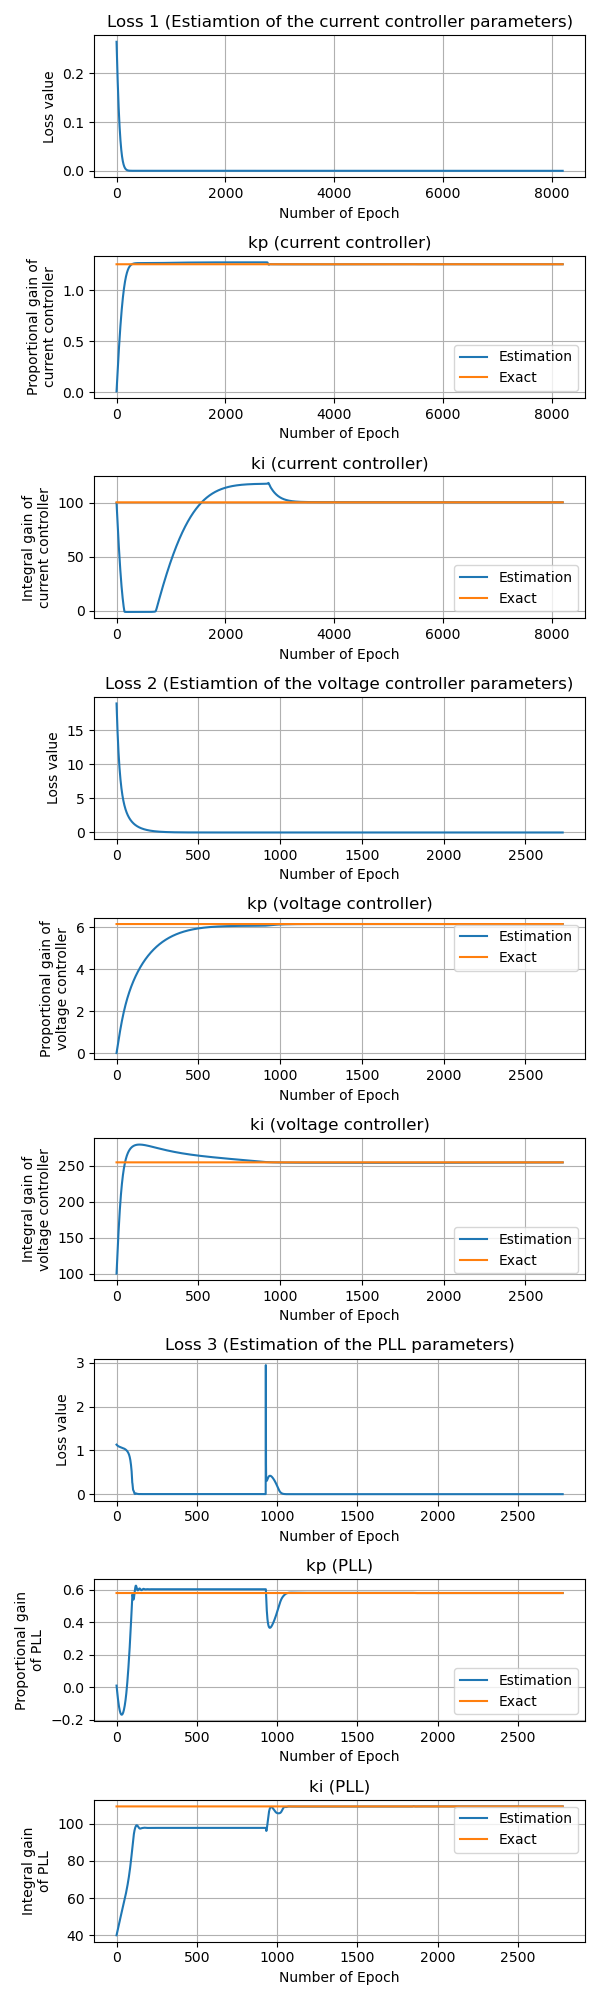

In [11]:
it = [np.arange(len(history[0])),np.arange(len(history[0])),np.arange(len(history[0])),
    np.arange(len(history[3])),np.arange(len(history[3])),np.arange(len(history[3])),
    np.arange(len(history[6])),np.arange(len(history[6])),np.arange(len(history[6]))]
Title = ['Loss 1 (Estiamtion of the current controller parameters)',
        'kp (current controller)','ki (current controller)',
        'Loss 2 (Estiamtion of the voltage controller parameters)',
        'kp (voltage controller)','ki (voltage controller)',
        'Loss 3 (Estimation of the PLL parameters)',
        'kp (PLL)','ki (PLL)']
fig,axes = plt.subplots(9,1,figsize = [6,20])
for idx,axis in enumerate(axes):
    if idx==0 or idx==3 or idx==6:
        axis.plot(it[idx],history[idx])
        axis.set_ylabel('Loss value')
    if idx==1:
        axis.plot(it[idx],history[idx],label='Estimation')
        axis.plot(it[idx],Kpi*np.ones(it[idx].shape[0]),label='Exact')
        axis.set_ylabel('Proportional gain of\ncurrent controller')
        axis.legend()
    if idx==2:
        axis.plot(it[idx],history[idx],label='Estimation')
        axis.plot(it[idx],Kii*np.ones(it[idx].shape[0]),label='Exact')
        axis.set_ylabel('Integral gain of\ncurrent controller')
        axis.legend()
    if idx==4:
        axis.plot(it[idx],history[idx],label='Estimation')
        axis.plot(it[idx],Kpu*np.ones(it[idx].shape[0]),label='Exact')
        axis.set_ylabel('Proportional gain of\nvoltage controller')
        axis.legend()
    if idx==5:
        axis.plot(it[idx],history[idx],label='Estimation')
        axis.plot(it[idx],Kiu*np.ones(it[idx].shape[0]),label='Exact')
        axis.set_ylabel('Integral gain of\nvoltage controller')
        axis.legend()
    if idx==7:
        axis.plot(it[idx],history[idx],label='Estimation')
        axis.plot(it[idx],Kppll*np.ones(it[idx].shape[0]),label='Exact')
        axis.set_ylabel('Proportional gain\nof PLL')
        axis.legend()
    if idx==8:
        axis.plot(it[idx],history[idx],label='Estimation')
        axis.plot(it[idx],Kipll*np.ones(it[idx].shape[0]),label='Exact')
        axis.set_ylabel('Integral gain\nof PLL')
        axis.legend()
    axis.set_xlabel('Number of Epoch')
    axis.set_title(Title[idx])
    axis.grid(True)
plt.tight_layout()

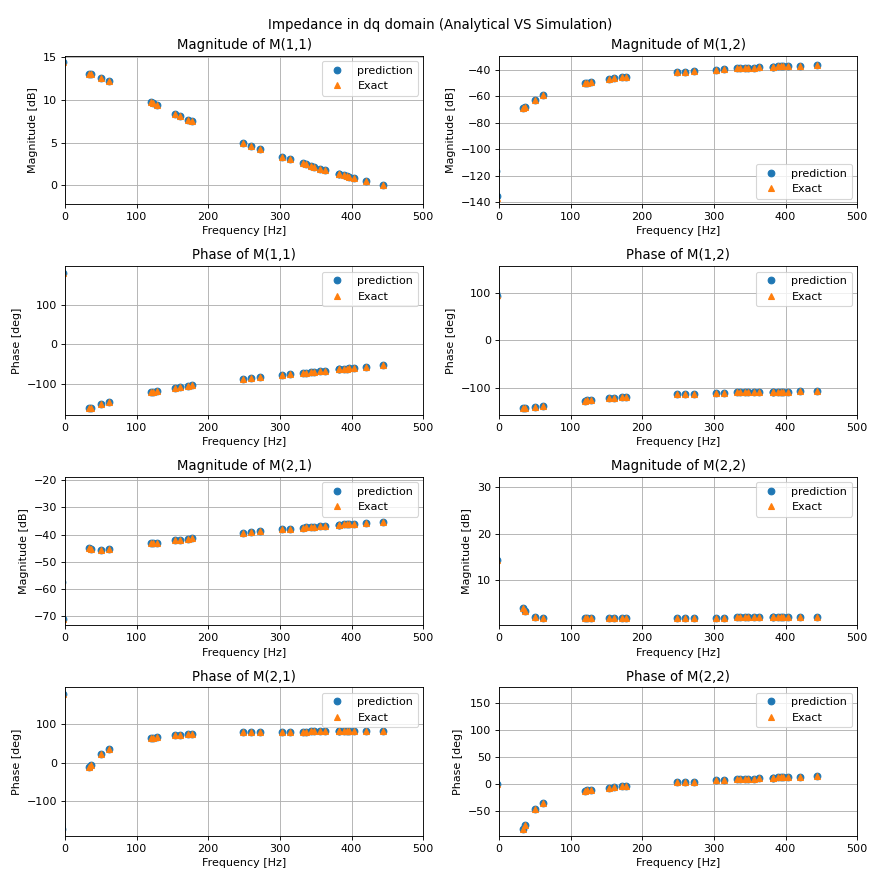

In [12]:
Ana_model_lf_pred = im.Impedance_model1(PIML.Rfilter_es,PIML.Lfilter_es,PIML.kpi_es,PIML.kii_es,PIML.kppll_es,
                    PIML.kipll_es,PIML.kpu_es,PIML.kiu_es,PIML.fsw_es,PIML.Cout_es,PIML.Vdc_es,Grid_freq,Grid_Vsdq,
                    DCFC_Power,f_sweep_lf_ts)

Z_lf_pred = Ana_model_lf_pred.Zvd_vl_dq.numpy()

SA.Impedance_plotting(Ana_model_lf.f_dq,Ana_model_lf.f_dq,0,'Impedance in dq domain (Analytical VS Simulation)',[0,500],
                        'o','^',**{'prediction':Z_lf_pred,'Exact':Ana_model_lf.Zvd_vl_dq})

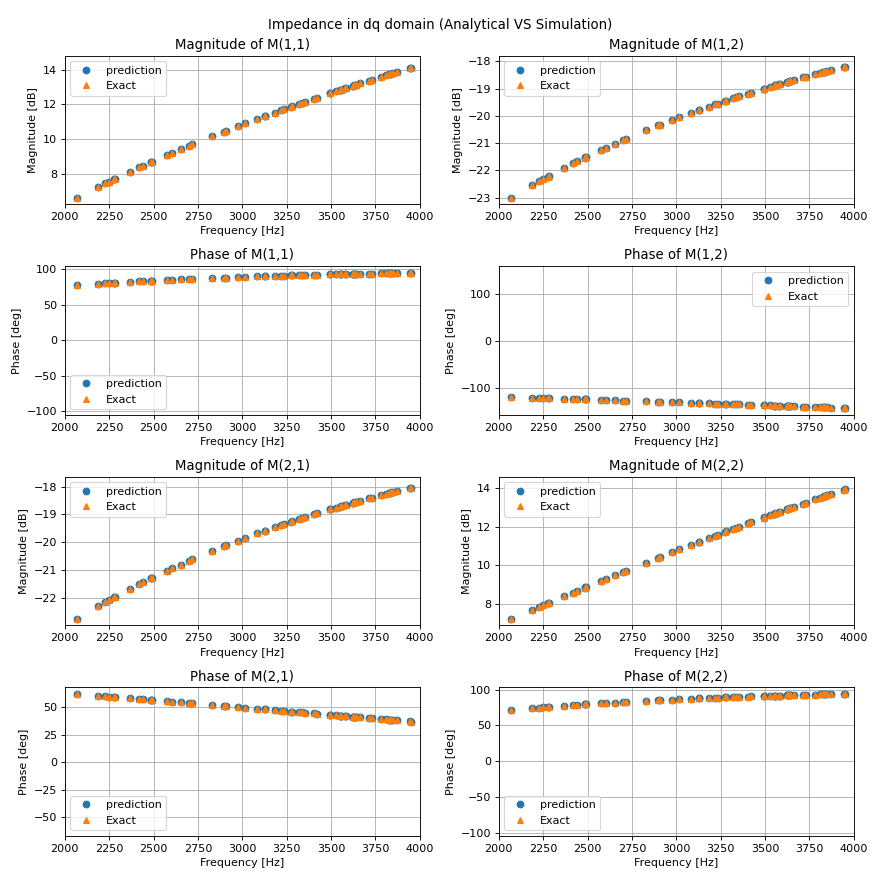

In [13]:
Ana_model_hf_pred = im.Impedance_model1(PIML.Rfilter_es,PIML.Lfilter_es,PIML.kpi_es,PIML.kii_es,PIML.kppll_es,
                    PIML.kipll_es,PIML.kpu_es,PIML.kiu_es,PIML.fsw_es,PIML.Cout_es,PIML.Vdc_es,Grid_freq,Grid_Vsdq,
                    DCFC_Power,f_sweep_hf_ts)

Z_hf_pred = Ana_model_hf_pred.Zvd_vl_dq.numpy()

SA.Impedance_plotting(Ana_model_hf.f_dq,Ana_model_hf.f_dq,0,'Impedance in dq domain (Analytical VS Simulation)',[2000,4000],
                        'o','^',**{'prediction':Z_hf_pred,'Exact':Ana_model_hf.Zvd_vl_dq})